# Function Testing Notebook - Joseph

**NOTE: this notebook is run on a Windows machine**

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [22]:
import sys
from pathlib import Path
import time
import tempfile

import numpy as np
import matplotlib.pyplot as plt

packageroot = Path('../../').resolve()
print(packageroot)
sys.path.append(str(packageroot))


C:\Users\User\source-code\PyEEG


In [23]:
from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'LongRecordingAnalyzer', 'MountainSortOrganizer']


In [24]:
# tempfile.tempdir = '/scr1/users/dongjp'

In [25]:
temppath = Path("./test-data/A10 KO 12_13_2023/Cage 2 A10-0_Meta.csv").resolve()
tmpmet = core.DDFBinaryMetadata(temppath)
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Wed Dec 13 11:17:32 2023


['Intan Input (1)/PortC C-009',
 'Intan Input (1)/PortC C-010',
 'Intan Input (1)/PortC C-012',
 'Intan Input (1)/PortC C-014',
 'Intan Input (1)/PortC C-015',
 'Intan Input (1)/PortC C-016',
 'Intan Input (1)/PortC C-017',
 'Intan Input (1)/PortC C-019',
 'Intan Input (1)/PortC C-021',
 'Intan Input (1)/PortC C-022']

In [26]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:170: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:257: UserWarning: Row-major binary files already exist! Skipping existing files
  warnings.warn("Row-major binary files already exist! Skipping existing files")


In [27]:
lan = core.LongRecordingAnalyzer(lrec, 10)

lan.setup_njobs()
mags = []
phases = []

for i in range(lan.n_fragments // 100):
    if i == 20:
        break
    t = time.process_time()

    # lan.compute_nspike(i)
    # csd = lan.compute_csd(i)
    # plt.imshow(csd['alpha'])

    coh = lan.compute_cohere(i)
    plt.imshow(coh['gamma'])

    pcorr = lan.compute_pcorr(i)
    plt.imshow(pcorr)

    # cacoh = lan.compute_cacoh(i)
    # plt.imshow(cacoh[0])

    # cacoh = lan.compute_cacoh(i, freq_res=1, indices=([[0,1,2,3]], [[4,5,6,7]]))
    # mags.append(cacoh[0])
    # phases.append(cacoh[1])


    # fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    # ax[0].imshow(corr)
    # ax[1].imshow(pcorr)
    # plt.show()

# _, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=True)
# mags = np.stack(mags, axis=-1).mean(axis=-1)
# phases = np.stack(phases, axis=-1).mean(axis=-1)
# ax[0].semilogx(cacoh[2], mags.transpose())
# ax[1].semilogx(cacoh[2], phases.transpose(), c='C1')
# ax[0].set_title("Magnitude")
# ax[1].set_title("Phase")
# plt.show()


In [28]:
Path('./test-wars/A10').resolve()

WindowsPath('C:/Users/User/source-code/PyEEG/notebooks/tests/test-wars/A10')

In [29]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25']
animal_ids = ['A10']
base_folder = Path('./test-data').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=5)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec()

    war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='serial')
    war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
# result = ao.compute_windowed_analysis(['cohere', 'pcorr']) # nspike needs work
# result = ao.compute_windowed_analysis(['nspike', 'wavetemp']) # nspike needs work
# result = ao.compute_windowed_analysis(['psd', 'cohere'], welch_bin_t=2, magnitude=False)

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:170: UserWarning: truncate = True. Only the first 5 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:257: UserWarning: Row-major binary files already exist! Skipping existing files
  warnings.warn("Row-major binary files already exist! Skipping existing files")


Processing serially


Processing rows:  97%|█████████▋| 30/31 [00:02<00:00, 14.02it/s]c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 360, using nperseg = 360
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 360, using nperseg = 360
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 360, using nperseg = 360
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 360, using nperseg = 360
  freqs, _, Pxy = _s

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']



C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-014 does not

In [30]:
war = visualization.WindowAnalysisResult.from_pickle_and_json(Path('./test-wars/A10').resolve())

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-014 does not 

In [31]:
war.get_result(['all'], allow_missing=True)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdslope,cohere,pcorr,nspike,wavetemp
0,0,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:31.640,True,"[45.94372, 79.14008, 35.041542, 72.76703, 49.0...","[2109.172, 6243.4824, 1227.7904, 5292.8623, 23...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2147.5413, 5670.243, 1340.4014, 4999.6924, 22...","{'delta': [1880.651, 2076.6306, 1154.8229, 248...","[(-2.516556542982667, 3.339854994560498), (-1....","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
1,1,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:35.640,True,"[17.386616, 104.45952, 17.702452, 87.68795, 40...","[300.913, 10911.759, 312.7414, 7676.2407, 1618...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[207.7021, 10274.227, 222.30768, 7361.2275, 14...","{'delta': [113.76094, 4511.131, 144.73114, 301...","[(-1.9418278507528686, 2.3862405613961064), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
2,2,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:39.640,True,"[21.215885, 101.42181, 17.910995, 85.188, 48.4...","[448.86877, 10286.33, 319.65482, 7256.164, 234...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[350.06873, 9339.711, 208.8498, 6142.2837, 221...","{'delta': [217.75006, 3193.6636, 138.69931, 22...","[(-2.0252361829090666, 2.5373860987949426), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
3,3,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:43.640,True,"[16.12407, 86.00608, 14.081851, 77.030235, 47....","[258.85803, 7396.576, 197.52907, 5932.884, 224...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[205.50983, 5805.3325, 162.63419, 5797.3716, 1...","{'delta': [144.83963, 2967.7048, 88.54566, 256...","[(-1.878583068187984, 2.2407929852186332), (-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
4,4,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:47.640,True,"[18.514677, 95.01188, 19.664534, 86.26501, 54....","[342.501, 9017.05, 386.6909, 7437.016, 2952.83...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[243.04065, 8636.447, 212.43747, 7553.8423, 27...","{'delta': [179.50603, 5810.311, 149.20937, 423...","[(-1.9923898978108705, 2.3884164109562898), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
5,5,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:51.640,True,"[23.877338, 95.443886, 23.73788, 80.194534, 50...","[568.7808, 9108.101, 562.67206, 6429.9507, 255...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[213.43088, 7921.8774, 291.69244, 6207.8657, 2...","{'delta': [120.490875, 3713.3074, 199.98892, 1...","[(-1.8050483426980943, 2.2184395866016042), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
6,6,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:55.640,True,"[17.575144, 114.5662, 16.79939, 84.01456, 37.3...","[308.21527, 13100.108, 281.65524, 7058.0405, 1...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[176.7713, 12810.948, 235.34874, 5670.9927, 12...","{'delta': [105.5144, 4303.0293, 169.70787, 273...","[(-1.8683339882648682, 2.2500073048152434), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN
7,7,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:59.640,True,"[18.340143, 83.75159, 15.620063, 96.09964, 40....","[335.4192, 7007.6665, 241.92899, 9235.017, 165...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[263.39035, 6600.198, 209.34328, 9103.471, 143...","{'delta': [175.6424, 1057.5573, 134.45265, 

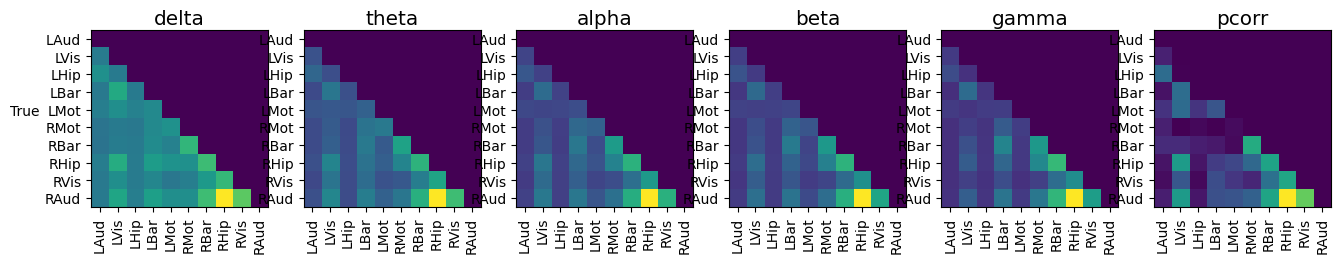

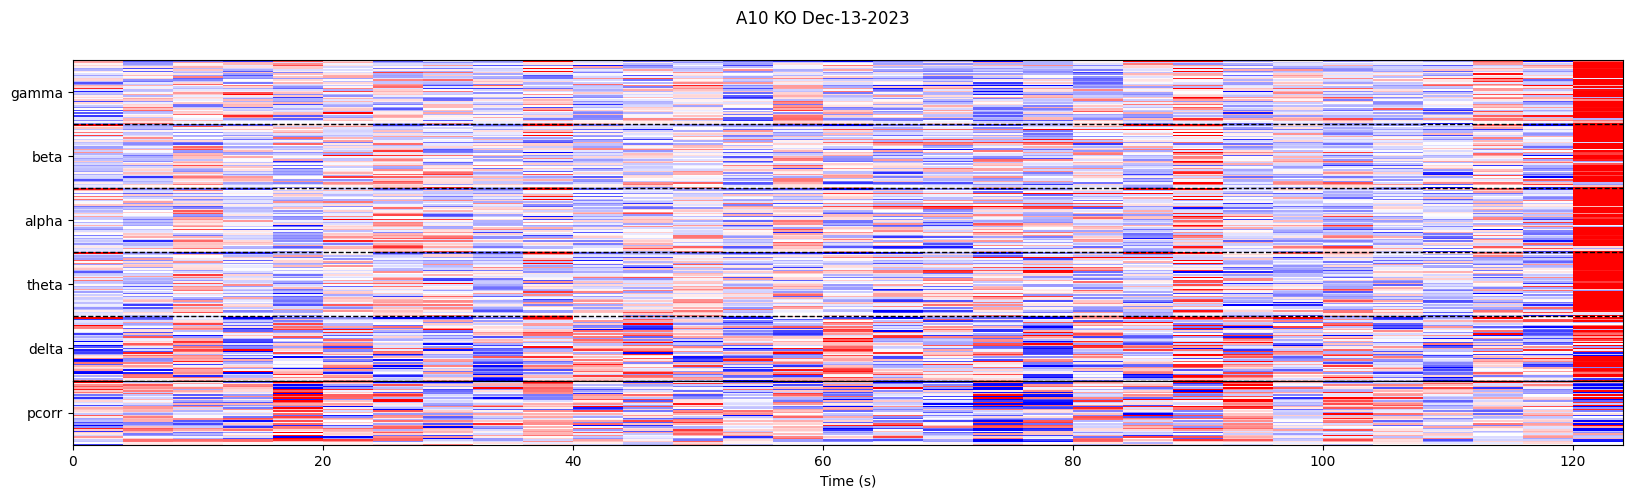

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\animal.py:331: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


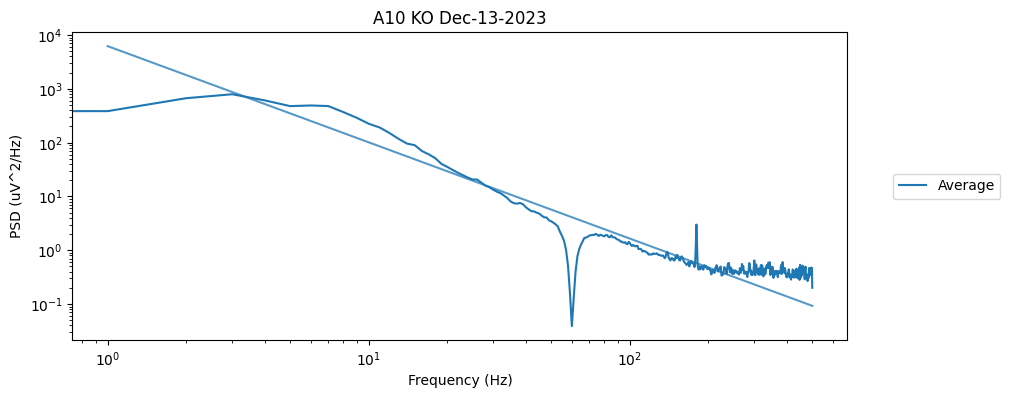

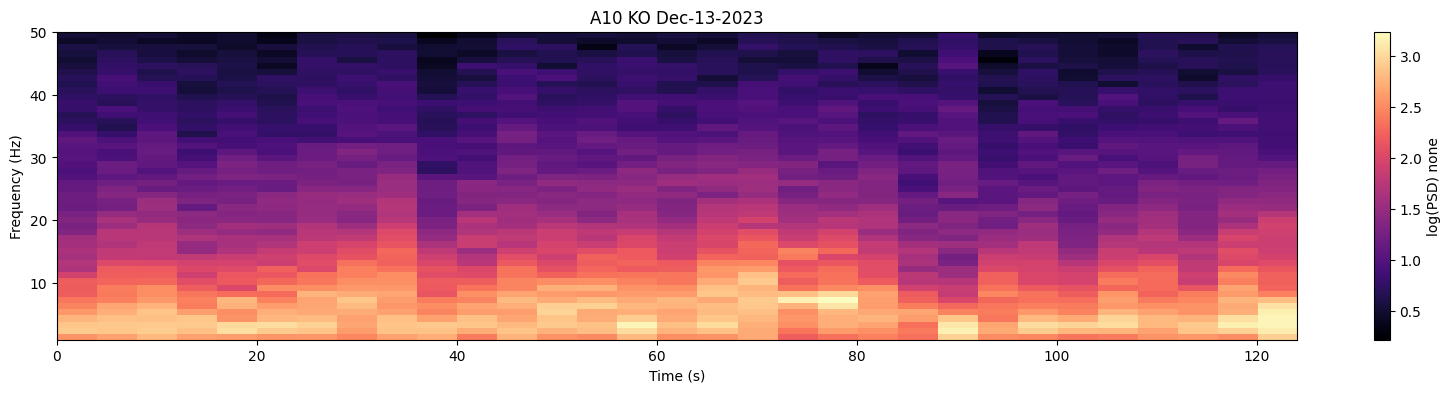

In [32]:
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
  warnings.warn(f"{channel_name} does not match name aliases. Assuming alias from number in channel name.")
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\results.py:85: UserWarning: Intan Input (1)/PortC C-014 does not 

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='animal', ylabel='rms'>,
 None)

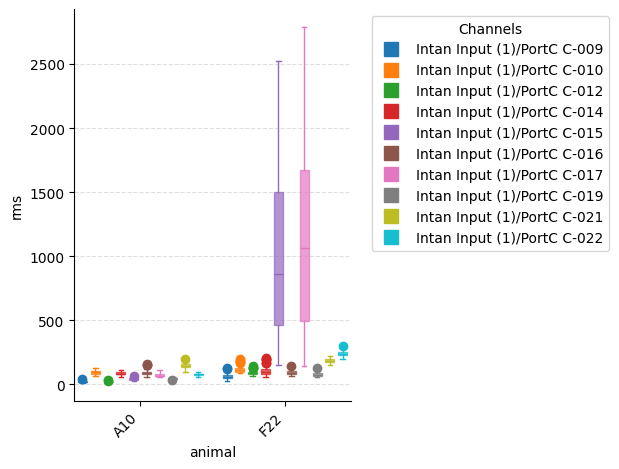

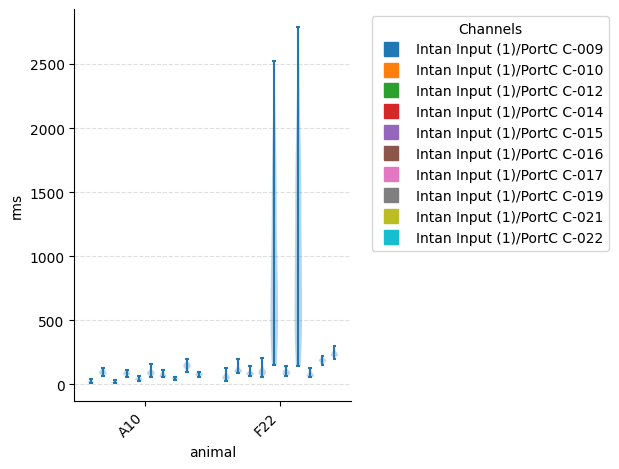

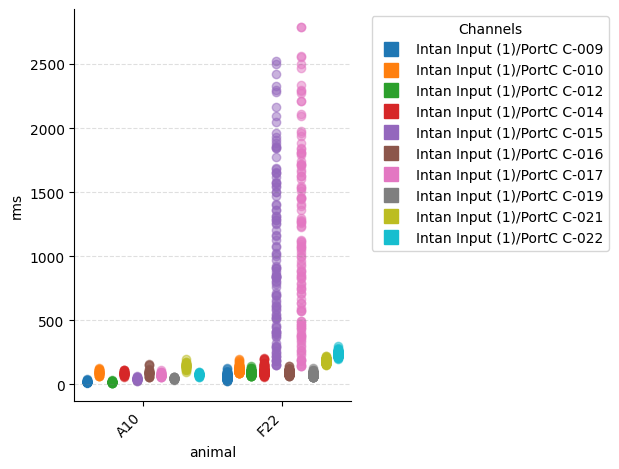

In [33]:
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    wars.append(visualization.WindowAnalysisResult.from_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve()))
ep = visualization.ExperimentPlotter(wars)
ep.plot_boxplot('rms')
ep.plot_violin('rms')
ep.plot_scatter('rms')